<a href="https://colab.research.google.com/github/JLDaniel77/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

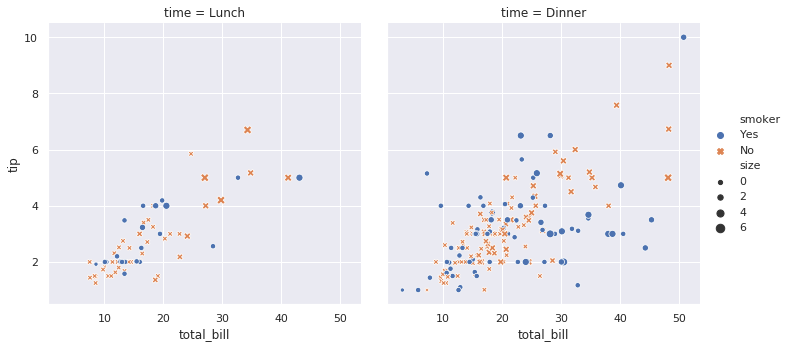

In [1]:
# TODO - your code here
# Use what we did live in lecture as an example
# !pip install seaborn --upgrade

import seaborn as sns

sns.set()

tips = sns.load_dataset('tips')

sns.relplot(x="total_bill", y="tip", col="time", hue="smoker", style="smoker",
            size="size", data=tips);

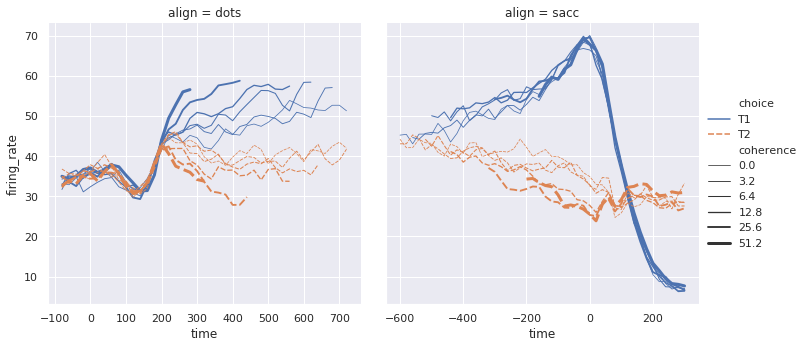

In [8]:
dots = sns.load_dataset("dots")

sns.relplot(x='time', y='firing_rate', col='align', hue='choice', size='coherence',
           style='choice', facet_kws=dict(sharex=False), 
           kind='line', legend='full', data=dots);

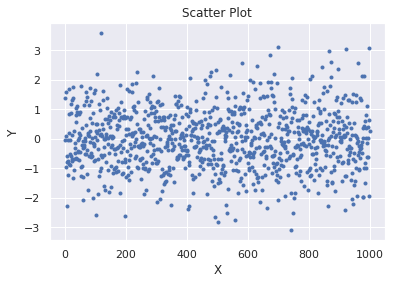

In [16]:
import numpy.random as np
import matplotlib.pyplot as plt

# Generate random dataset
x = np.randn(1000)

plt.plot(x,'.')
plt.title('Scatter Plot')
plt.xlabel('X')
plt.ylabel('Y')
plt.draw()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

2.  What was the most challenging part of what you did?

3.  What was the most interesting thing you learned?

4.  What area would you like to explore with more time?




1. Above are 3 graphs generated in Python. The first 2 graphs were created with the Seaborn library, and the 3rd graph was generated using Matplotlib. The first graph is a relational scatter plot showing the change in a server's tip depending on various conditions (the total amount of the bill, the time of day, the size of the group, and whether or not the customer was a smoker). The second graph is using data from the 'dots' dataset and shows the relationship between time and firing rate. I'm not sure what this dataset is measuring, but I thought the graphs looked cool. The third graph is a scatter plot using a randomly generated dataset, and it shows the distribution of the randomly selected data points.

2. I ran into an issue using the Seaborn relplot() plot. I received an error that module seaborn does not have attribute relplot. I did a Google search and found that the error is due to colab using an older version of seaborn that doesn't have the relplot() plot. An answer on Stack Overflow had a code snippet on how to update seaborn to the latest version. I updated the Seaborn library and my code worked as expected.

3. Most of my experience in plotting graphs in Python is limited to plotting 1 independent varible on the X-axis and 1 dependent variable on the Y-axis, to see the relationship between them. I liked how relplot allows you to plot multiple varibles on the same graph to see how each variable affects the dependent variable. I also liked how relplot splits the data into multiple graphs based on the column argument.

4. With more time, I would like to understand the second set of plots with the 'dots' dataset. I like the design of the graphs, but I have no idea what they tell about the data.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.